#  Partial Least Squares (PLS) Regression
In this example, I will show how to use PLS to predict the quality of wine based on some physiochemical properties of the wine. 

In [1]:
import pandas as pd
import numpy as np

## load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import matplotlib
plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

## load sklearn
from sklearn import cross_validation
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error


//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Load dataset
There are two datasets: white wine and red wine. 

In [2]:
red=pd.read_csv('/Users/oladipoositelu/Desktop/data/winequality-red.csv',sep=";")
white=pd.read_csv('/Users/oladipoositelu/Desktop/data/winequality-white.csv',sep=';')

In [3]:
# Create a variable that says what color the wine is
red['color']='red'
white['color']='white'

In [4]:
df=pd.concat([red,white]) # merge the two datasets

In [5]:
color_dum=pd.get_dummies(df.color) # create dummy variable for the wine color
df=pd.concat([df,color_dum],axis=1)

## Summary Statistics and Histograms of the data 

In [6]:
df.shape

(6497, 15)

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10521e410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112cbc650>]], dtype=object)

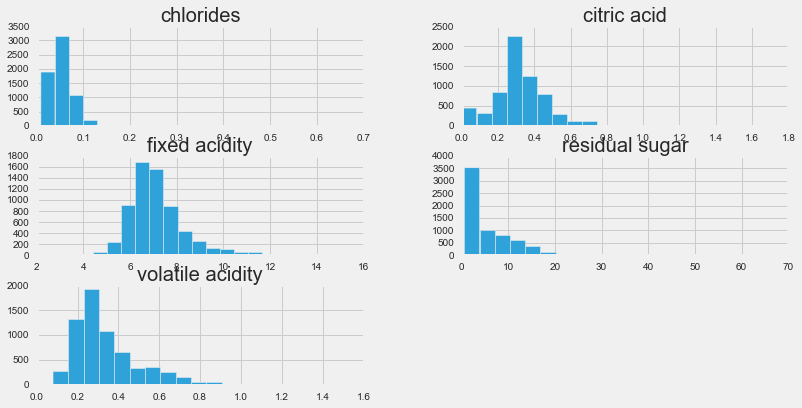

In [8]:
df[['fixed acidity','volatile acidity', 'citric acid','chlorides','residual sugar']].hist(bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113787ad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112b038d0>]], dtype=object)

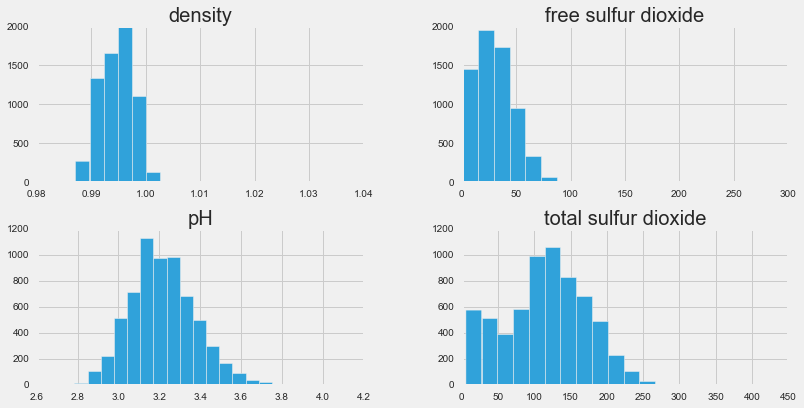

In [9]:
df[['free sulfur dioxide','total sulfur dioxide', 'density','pH']].hist(bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113ddc1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114204610>]], dtype=object)

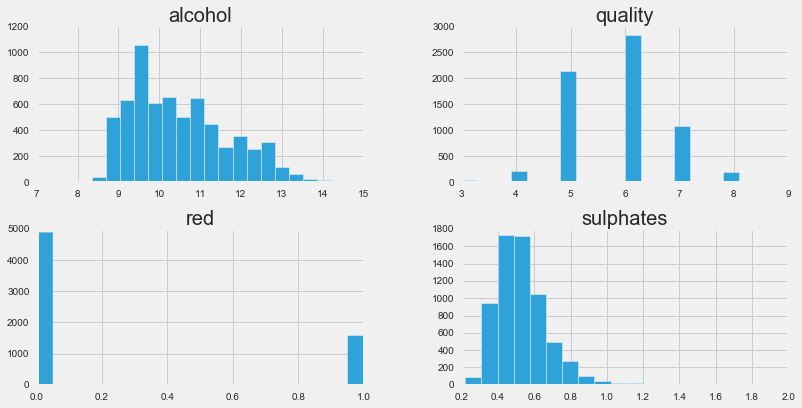

In [10]:
df[['sulphates','alcohol', 'quality','red']].hist(bins=20)

## Pairplot of variables by color of wine 

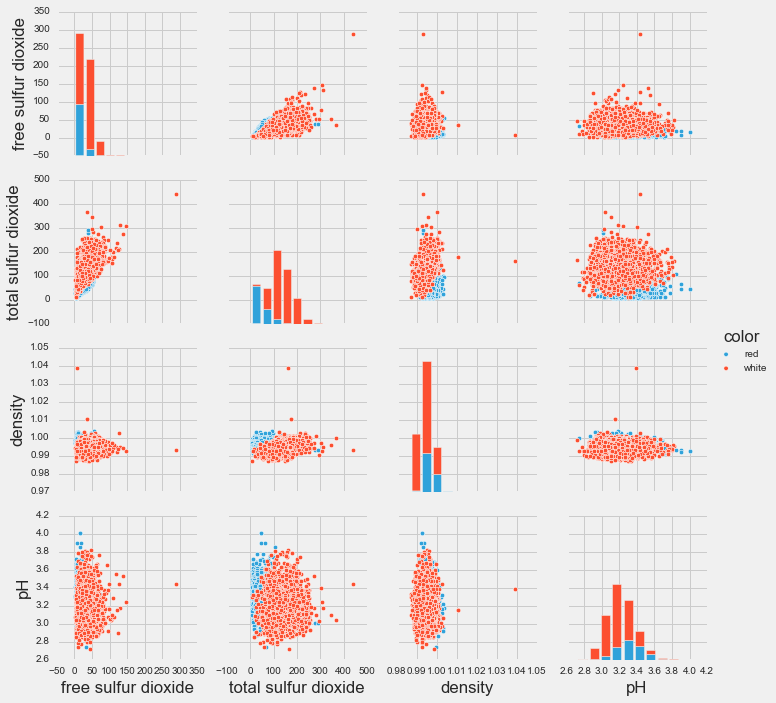

In [11]:
sns.pairplot(df[['free sulfur dioxide','total sulfur dioxide', 'density','pH','color']],hue='color')

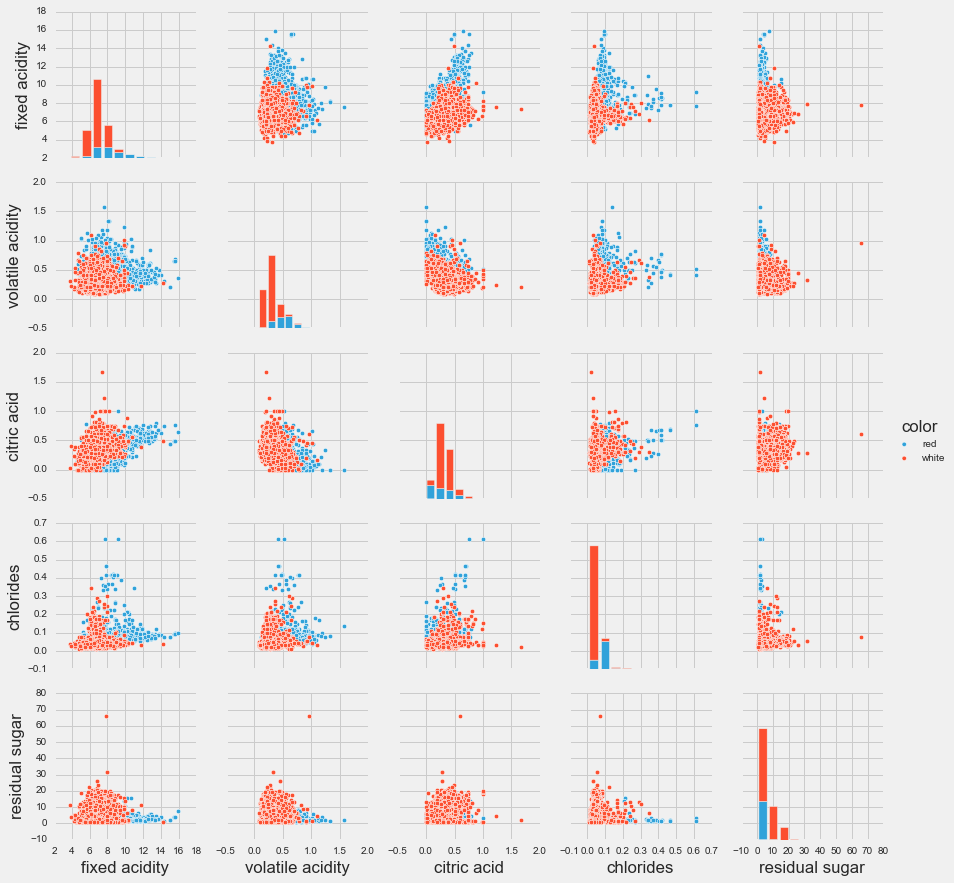

In [12]:
sns.pairplot(df[['fixed acidity','volatile acidity', 'citric acid','chlorides','residual sugar','color']],hue='color')

### Quality based on color

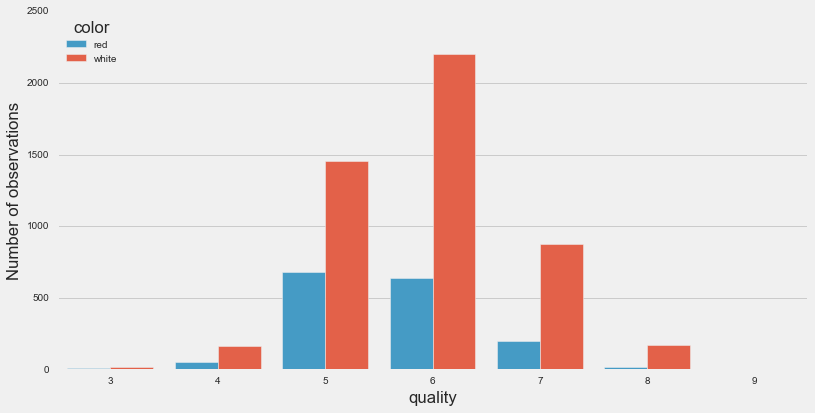

In [13]:
sns.countplot(df.quality,hue=df.color)
plt.ylabel('Number of observations')

## Some Notes
1.All the variables appear to be continuous variables besides color which is a dummy variable

2.No missing data

3.Response variable quality is concentrated between 5 and 7

4.The prediction models will struggle to predict values less than 5 and values greater than 7 since they are so few

5.There's a lot more white wine than red wine

In [14]:
df=df.drop(['white','color'],axis=1) #drop one of the dummy variables

## Correlation Matrix 

In [15]:
cor = df.drop('red',axis=1).corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.40) | (cor < -0.40)] #show variables with at least correlation of 0.4

free sulfur dioxide   residual sugar         0.402871
total sulfur dioxide  volatile acidity      -0.414476
                      residual sugar         0.495482
                      free sulfur dioxide    0.720934
density               fixed acidity          0.458910
                      residual sugar         0.552517
alcohol               density               -0.686745
quality               alcohol                0.444319
dtype: float64

In [16]:
from scipy import stats

In [17]:
#DF=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] #drop outliers. Any value that is more than 3 standard deviation

## Create x and y variables

I will drop the dummy variable for white because red and white are perfectly correlated (if the wine is white, we know it's not red). This avoids the dummy variable trap


In [41]:
x=df.drop(['quality',],axis=1) # 
y=df.quality

In [42]:
white_x=white.drop(['quality','color'],axis=1)
white_y=white.quality
red_x=red.drop(['quality','color'],axis=1)
red_y=red.quality

In [43]:
## Create train and test data for the entire sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
## Create train and test data for the white wine sample
white_X_train, white_X_test, white_y_train, white_y_test = train_test_split(white_x, white_y, test_size=0.2, random_state=42)
## Create train and test data for the red whine sample
red_X_train, red_X_test, red_y_train, red_y_test = train_test_split(red_x, red_y, test_size=0.2, random_state=42)

## Partial least squares
We need to determine the number of principal components to use in the PLS. This will be determined using 10 folds Cross Validation.

The prediction metric is mean absolute error

Use 11 components


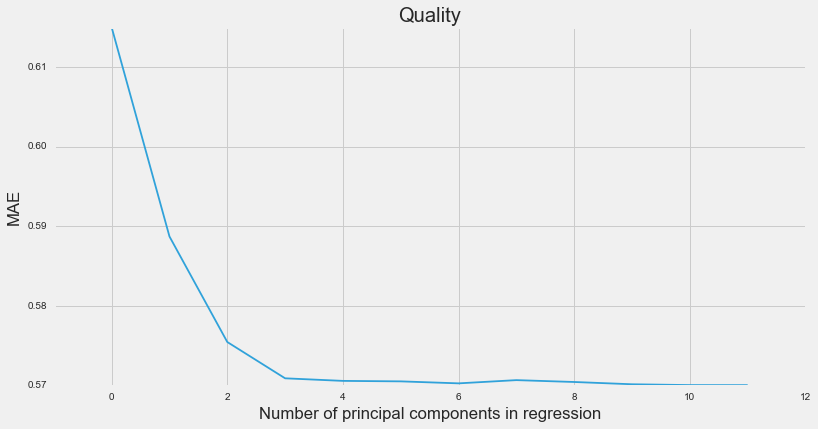

In [44]:
n = len(X_train)

kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=42)
mae = []
for i in range(1, 13):
    pls = PLSRegression(n_components=i)
    score = cross_validation.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='mean_absolute_error').mean()
    mae.append(-score)
    
# Plot results
plt.plot(mae,linewidth=1.8)
plt.xlabel('Number of principal components in regression')
plt.ylabel('MAE')
plt.title('Quality')
plt.xlim(xmin=-1)
#print "Use " + str(np.argmin(mae)) + " components"

In [46]:
pls = PLSRegression(n_components=6)
pls.fit(scale(X_train), y_train)
print mean_absolute_error(y_test, pls.predict(scale(X_test)))

0.566282533674


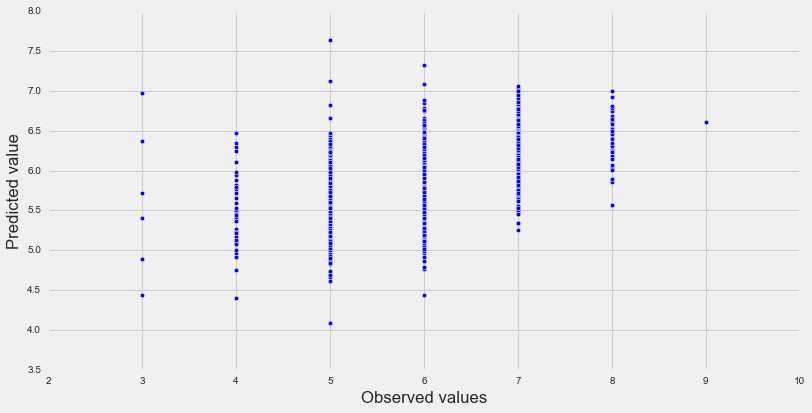

In [47]:
plt.scatter(y_test,pls.predict(scale(X_test)))
plt.xlabel('Observed values')
plt.ylabel('Predicted value')

As expected the model doesn't do very well predicting quality that is neither 5 nor 6. It has too few instances of those qualities to learn from

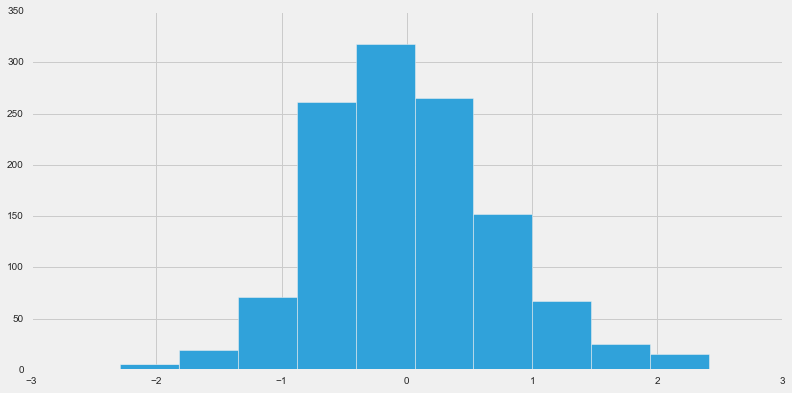

In [40]:
predicted=pd.DataFrame(pls.predict(scale(X_test)),columns={'predicted'})
yy=y_test.reset_index()
(yy['quality']-predicted['predicted']).hist()